This notebook is by Anastasia Ruzmaikina.

In this notebook we use the XGBoost Classifier to classify a wine as 'high quality' or 'low quality' based on eleven attributes such as density, sulfates, alhohol, fixed acidity etc. We use a data set of 6496 wines.

We use the XGBoost Classifier to predict if a wine is high quality.

XGBoost Classifier achieves the accuracy of 82% which is about 6% more accurate than the Decision Tree Classfier. XGBoost Classifier achieves close to optimal accuracy with the default parameter values. However it is difficult to fine tune to improve its accuracy. Increasing the number of trees used does not improve the accuracy of XGBoost Classifier.

In [1]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
# Gridsearchcv for hyperparameter tuning
# train_test_split for splitting

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
#these are classification evaluation metric

from sklearn.preprocessing import normalize, StandardScaler

import xgboost as xgb
# xgboost for performing classification

from sklearn.metrics import roc_auc_score
import time
import warnings
warnings.filterwarnings('ignore')

First we load the data and understand the data.

In [2]:
wine = pd.read_csv('wine.csv')

In [3]:
wine.shape

(6497, 14)

In [4]:
wine

,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color,high_quality
0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,red,0
1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,red,0
2,2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,red,0
3,3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,red,1
4,4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,red,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,white,1
6493,6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,white,0
6494,6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,white,1
6495,6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,white,1


The column 'Unnamed: 0' carries no new information, so we drop it.

In [5]:
wine.drop(['Unnamed: 0'], axis=1, inplace=True)

We look if there are any missing values.

In [6]:
# Get count of missing values in every column
print(wine.isna().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
color                   0
high_quality            0
dtype: int64


We can look at the column statistics.

In [7]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,high_quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,0.633061
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.482007
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,1.000000


Exploratory Data Analysis

In [8]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  color                 6497 non-null   object 
 12  high_quality          6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


The column 'color' is categorical, so we do a one hot encoding to get two numerical columns: 'color_red' and 'color_white'.

In [9]:
color_dummies= pd.get_dummies(data=wine, columns=['color'])
wine = color_dummies

In [10]:
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,high_quality,color_red,color_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,1,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0,1,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0,1,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,1,1,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,1,0,1
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0,0,1
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,1,0,1
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,1,0,1


We take a look at the target column.

In [11]:
# The high_quality is the target column y.
wine.high_quality.value_counts()

1    4113
0    2384
Name: high_quality, dtype: int64

We can plot a pie chart for the distribution of values in the 'high_quality' column.



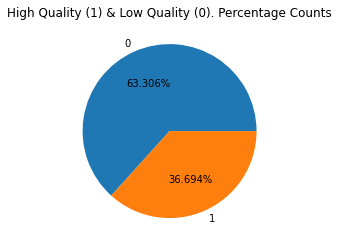

In [12]:
# get the set of distinct classes
labels = wine.high_quality.unique()

# get the count of each class
sizes = wine.high_quality.value_counts().values

# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('High Quality (1) & Low Quality (0). Percentage Counts')
plt.show()

To check the distribution of variables, we plot histograms of variables to find if they are normal or skewed.

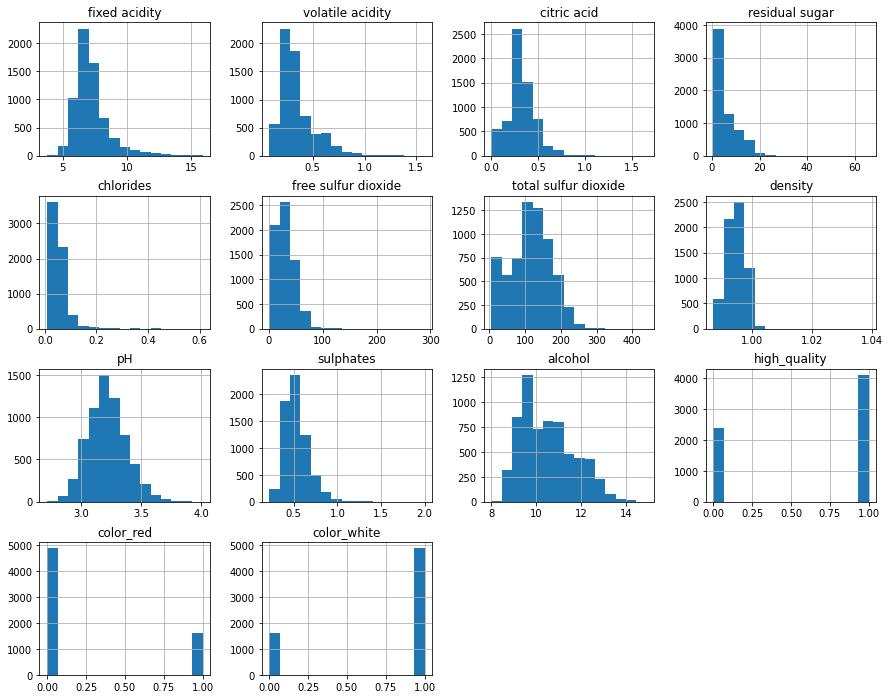

In [13]:
# plot histograms of the variables
params = wine

params.hist(figsize=(15,12),bins = 15)

plt.show()

We see that the columns 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide' have right skewed distributions, while other columns have more symmetric distributions.

We plot a heat map of the correlation coefficients between columns.

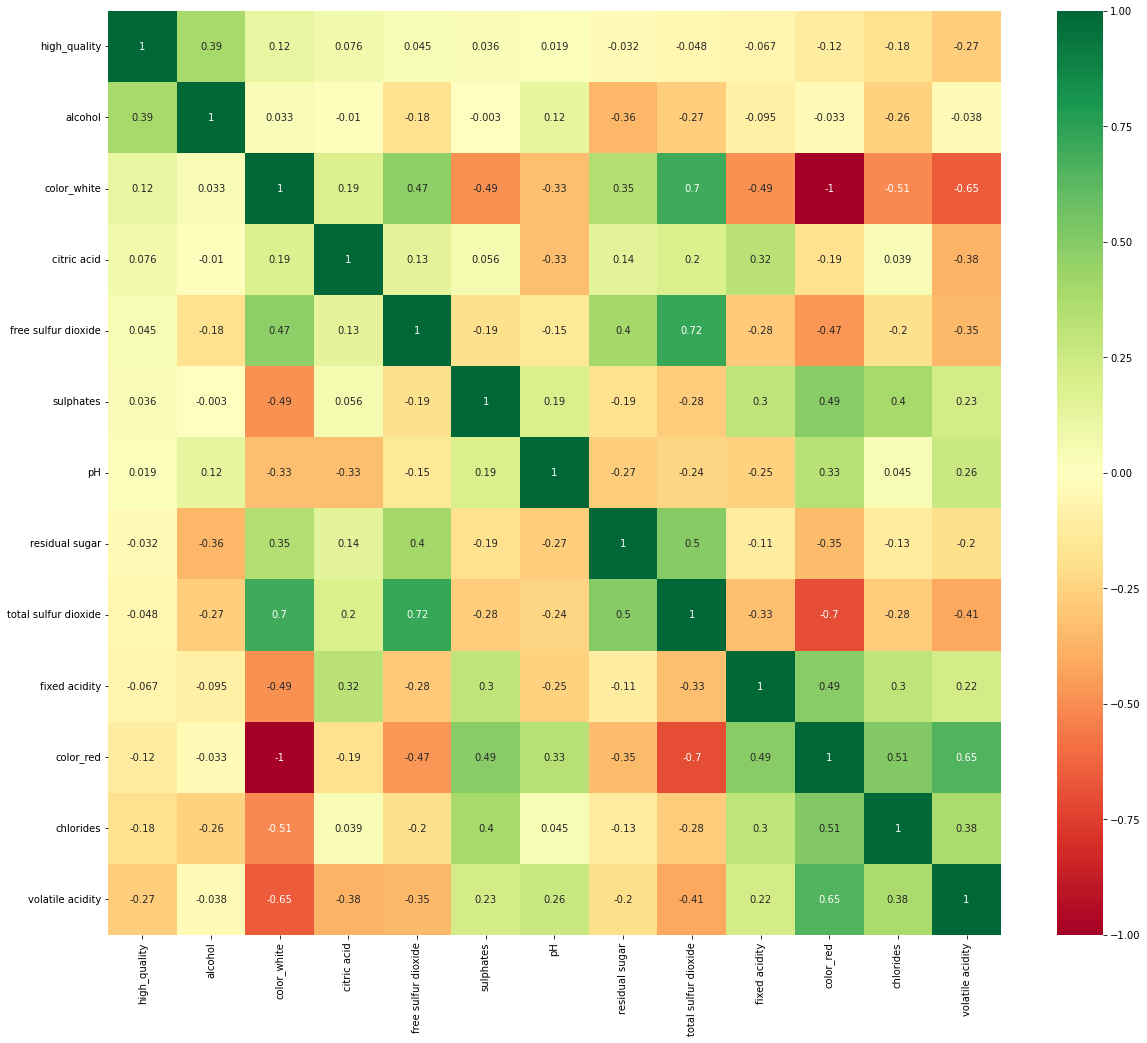

In [14]:
k = 13 #number of variables for heatmap
cols = wine.corr().nlargest(k, 'high_quality')['high_quality'].index
plt.figure(figsize=(20,17))
p = sns.heatmap(wine[cols].corr(), annot=True,cmap='RdYlGn',center=0) 
#correlation plot

Data Preprocessing:

In [15]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'high_quality', 'color_red',
       'color_white'],
      dtype='object')

First we rescale the data using the Standard Scaler to make sure that the columns with higher values do not have a disproportionate effect on the target variable.

We assign the first eleven columns and 13th and 14th column as predictors X. We assign the 12th column 'high_quality' as a target variable y.

In [16]:
# data preprocessing such as scaling/normalization is typically useful for 
# linear models to accelerate the training convergence

# standardize features by removing the mean and scaling to unit variance
wine.iloc[:, 0:11] = StandardScaler().fit_transform(wine.iloc[:, 0:11])
data_matrix = wine.values

# X: feature matrix (for this analysis, we exclude the 'high_value' variable from the dataset)
X = data_matrix[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13]]

# y: labels vector
y = data_matrix[:, 11]

# data normalization
X = normalize(X, norm="l1")

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

wine[0:11]

X.shape= (6497, 13) y.shape= (6497,)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,high_quality,color_red,color_white
0,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,0,1,0
1,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862469,0.701486,-0.115073,0.999579,-0.580068,0,1,0
2,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092486,0.768188,0.258120,0.797958,-0.580068,0,1,0
3,3.073817,-0.362438,1.661085,-0.744778,0.541412,-0.762074,-0.986324,1.101694,-0.363868,0.327510,-0.580068,1,1,0
4,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,0,1,0
5,0.142473,1.945855,-2.192833,-0.765798,0.541412,-0.987451,-1.340197,1.034993,1.813090,0.193097,-0.915464,0,1,0
6,0.528176,1.581387,-1.779913,-0.807837,0.370134,-0.874763,-1.004018,0.568084,0.506915,-0.478971,-0.915464,0,1,0
7,0.065333,1.885110,-2.192833,-0.891916,0.255949,-0.874763,-1.676376,-0.032228,1.066704,-0.411765,-0.412370,1,1,0
8,0.451036,1.459898,-2.055193,-0.723758,0.484319,-1.212828,-1.729457,0.701486,0.880108,0.260304,-0.831615,1,1,0
9,0.219614,0.973942,0.284686,0.138050,0.427227,-0.762074,-0.243191,1.034993,0.817909,1.806060,0.006875,0,1,0


We split the data into the training set and the test set.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)       
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (4547, 13) Y_train.shape= (4547,)
X_test.shape= (1950, 13) Y_test.shape= (1950,)


In [18]:
X_train

array([[-0.01053015,  0.07215247, -0.03962261, ...,  0.12985765,
         0.        ,  0.11838474],
       [ 0.01291513,  0.16537786, -0.09272478, ..., -0.07538551,
         0.09064952,  0.        ],
       [-0.01442952, -0.05259747,  0.11441724, ..., -0.07224917,
         0.        ,  0.08687814],
       ...,
       [ 0.02831043, -0.08673205,  0.00089735, ..., -0.09533464,
         0.        ,  0.09540016],
       [-0.02159846,  0.00816314, -0.13301837, ..., -0.08633665,
         0.        ,  0.13004131],
       [-0.04316135, -0.01609408,  0.06616879, ...,  0.18166882,
         0.        ,  0.13472328]])

Model Building

Parameters for Tree Booster (from XGBoost website)

eta [default=0.3, alias: learning_rate] Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative. range: [0,1]

gamma [default=0, alias: min_split_loss] Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be. range: [0,∞]

max_depth [default=6] Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. exact tree method requires non-zero value. range: [0,∞]

min_child_weight [default=1] Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be. range: [0,∞]

max_delta_step [default=0] Maximum delta step we allow each leaf output to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative. Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced. Set it to value of 1-10 might help control the update. range: [0,∞]

subsample [default=1] Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration. range: (0,1]

lambda [default=1, alias: reg_lambda] L2 regularization term on weights. Increasing this value will make model more conservative.

alpha [default=0, alias: reg_alpha] L1 regularization term on weights. Increasing this value will make model more conservative.



First we build an XGBoost model using the default values of all of the parameters.

In [19]:
xgb_cls = xgb.XGBClassifier()

#initialize the xgb classifier 
xgb_cls.fit(X_train, y_train)

y_pred = xgb_cls.predict(X_test)

In [20]:
# evaluation metric

print('--------Classification report--------\n',classification_report(y_test, y_pred))
print('--------Confusion Matrix--------\n',confusion_matrix(y_test, y_pred))
print('Accuracy Score : %.2f'%accuracy_score(y_test, y_pred))
print('f1 score : %2f'%f1_score(y_test, y_pred))


--------Classification report--------
               precision    recall  f1-score   support

         0.0       0.77      0.71      0.74       716
         1.0       0.84      0.88      0.86      1234

    accuracy                           0.81      1950
   macro avg       0.80      0.79      0.80      1950
weighted avg       0.81      0.81      0.81      1950

--------Confusion Matrix--------
 [[ 505  211]
 [ 151 1083]]
Accuracy Score : 0.81
f1 score : 0.856804


Now we can try some different parameter values. For example, we can increase the number of trees to 1000. We can decrease the learning rate to 0.01.

In [31]:
xgb_cls = xgb.XGBClassifier(learning_rate = 0.01, n_estimators = 1000)

xgb_cls.fit(X_train, y_train)


y_pred = xgb_cls.predict(X_test)


print('--------Classification report--------\n',classification_report(y_test, y_pred))
print('--------Confusion Matrix--------\n',confusion_matrix(y_test, y_pred))
print('Test  accuracy Score : %.2f'%accuracy_score(y_test, y_pred))
print('f1 score : %2f'%f1_score(y_test, y_pred))

--------Classification report--------
               precision    recall  f1-score   support

         0.0       0.75      0.67      0.71       716
         1.0       0.82      0.87      0.84      1234

    accuracy                           0.80      1950
   macro avg       0.78      0.77      0.77      1950
weighted avg       0.79      0.80      0.79      1950

--------Confusion Matrix--------
 [[ 477  239]
 [ 159 1075]]
Test  accuracy Score : 0.80
f1 score : 0.843799


We see that decreasing the learning rate while increasing the number of trees does not improve accuracy, in fact the accuracy is 1% less than for the default values.

Let's decrease the number of estimators to 500 and take min_child_weight, minimum sum of instances for the child tree, to be 5.

In [34]:
xgb_cls = xgb.XGBClassifier(min_child_weight=5, learning_rate = 0.01, n_estimators = 500)

xgb_cls.fit(X_train, y_train)


y_pred = xgb_cls.predict(X_test)


print('--------Classification report--------\n',classification_report(y_test, y_pred))
print('--------Confusion Matrix--------\n',confusion_matrix(y_test, y_pred))
print('Test  accuracy Score : %.2f'%accuracy_score(y_test, y_pred))
print('f1 score : %2f'%f1_score(y_test, y_pred))

--------Classification report--------
               precision    recall  f1-score   support

         0.0       0.72      0.63      0.67       716
         1.0       0.80      0.86      0.83      1234

    accuracy                           0.77      1950
   macro avg       0.76      0.74      0.75      1950
weighted avg       0.77      0.77      0.77      1950

--------Confusion Matrix--------
 [[ 454  262]
 [ 178 1056]]
Test  accuracy Score : 0.77
f1 score : 0.827586


We see that increasing the min_child_weight lowers the accuracy score.

Hyperparameter Tuning

To find the best parameters for XGBoost algorithm, we need to do a grid search.

The main problem is the amount of time it takes.

For that reason, we keep the number of estimators low.

In [21]:
from sklearn.model_selection import GridSearchCV
#import grid searchcv for hypeparameter tuning

xgb_clf = xgb.XGBClassifier(objective=  'binary:logistic' ,learning_rate=0.1) #objective = logistic for binary classification
params = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight':[2,5,10],
        'gamma':[0,0.03,0.1,0.3],
        'reg_alpha':[1e-2,  0.5, 0.75, 0.9],
        'reg_lambda':[1e-2, 0.45, 0.8],
        }
#define params 


grid_search = GridSearchCV(xgb_clf, params, n_jobs=-1, cv = 3, verbose=1)

grid_search.fit(X_train, y_train)
#fit the params

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, m...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                        

In [22]:
#let's see the best parameters as per our grid search
grid_search.best_params_

{'gamma': 0.03,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 100,
 'reg_alpha': 0.9,
 'reg_lambda': 0.8}

In [24]:
y_pred = grid_search.predict(X_test)

print('After optimizing the hyperparameters\n')
print('--------Classification report--------\n',classification_report(y_test, y_pred))
print('--------Confusion Matrix--------\n',confusion_matrix(y_test, y_pred))
print('Test Accuracy Score : %.2f'%accuracy_score(y_test, y_pred))
print('f1 score : %2f'%f1_score(y_test, y_pred))

After optimizing the hyperparameters

--------Classification report--------
               precision    recall  f1-score   support

         0.0       0.78      0.69      0.73       716
         1.0       0.83      0.89      0.86      1234

    accuracy                           0.82      1950
   macro avg       0.81      0.79      0.80      1950
weighted avg       0.81      0.82      0.81      1950

--------Confusion Matrix--------
 [[ 496  220]
 [ 139 1095]]
Test Accuracy Score : 0.82
f1 score : 0.859160


XGBoost Classifier achieves the accuracy of 82% which is about 6% more accurate than the Decision Tree Classfier. XGBoost Classifier achieves close to optimal accuracy with the default parameter values. However it is difficult to fine tune to improve its accuracy. Increasing the number of trees used does not improve the accuracy of XGBoost Classifier.